In [1]:
import scripts.read_land_use_no_gdal as land_use
import scripts.read_image_data as rid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = rid.read_image_data(image_dir='2014/images/', mask_dir='2014/masks/', table_dir='2014/tables/LC8_SR.csv')
ds_new = rid.read_image_data(image_dir='2015/images/', mask_dir='2015/masks/', table_dir='2015/tables/LC8_SR.csv')

In [3]:
array, unique_classes = land_use.read_land_use(buffer=-0.001, 
                                               area_filter="POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869,\
                        143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978,\
                        143.32317350376297 -37.496296386368165))")

In [4]:
train, to_predict = rid.generate_interpolated_training_set(ds, ds_new, labels=array)

E:\Anaconda3\envs\earth_engine\lib\site-packages\pandas\tools\merge.py:205: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [5]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [6]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=20, random_state=0)

In [7]:
X = train.ix[train.ix[:, 'label'] != 0, 2:-1]
y = train.ix[train.ix[:, 'label'] != 0, 'label']

In [8]:
Counter(y)

Counter({1: 23487,
         2: 284100,
         3: 37352,
         4: 36835,
         5: 210006,
         6: 16442,
         7: 51447})

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          1       0.98      0.76      0.86      7836
          2       0.91      0.94      0.93     93557
          3       0.94      0.71      0.81     12446
          4       0.84      0.87      0.86     12166
          5       0.83      0.92      0.87     69348
          6       0.97      0.88      0.92      5483
          7       0.77      0.52      0.62     16855

avg / total       0.88      0.88      0.87    217691



In [10]:
X_new = to_predict.iloc[:, 2:]
pred_new = model.predict(X_new)
cls_table = to_predict.iloc[:, :2]
cls_table['pred_label'] = pred_new
cls_map = cls_table.pivot(index='x', columns='y', values='pred_label')

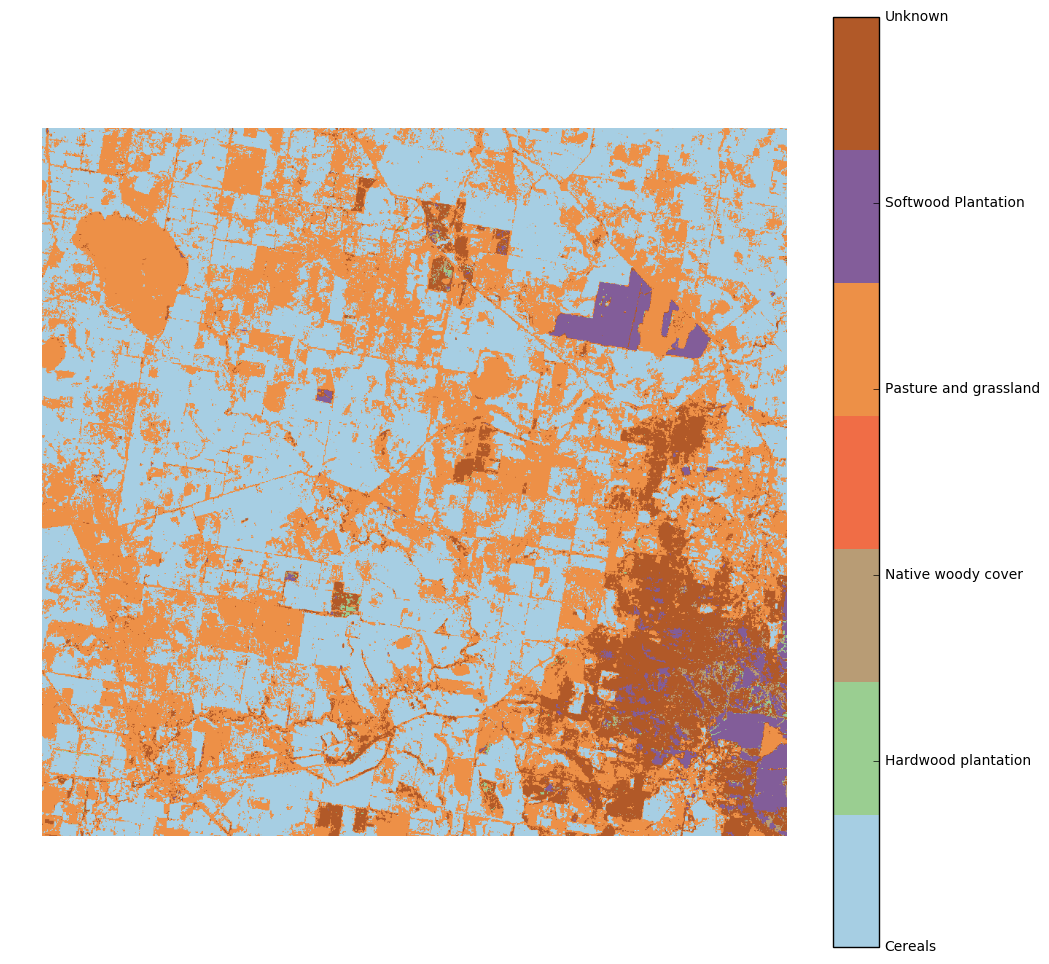

In [11]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cls_map, cmap=plt.cm.get_cmap('Paired', len(unique_classes) - 1))
plt.colorbar(ticks=range(1, len(unique_classes)), format=plt.FuncFormatter(lambda val, loc: unique_classes[val]))
plt.show()

In [12]:
Counter(pred_new)

Counter({2: 482309, 3: 1848, 4: 4402, 5: 389982, 6: 25810, 7: 90055})

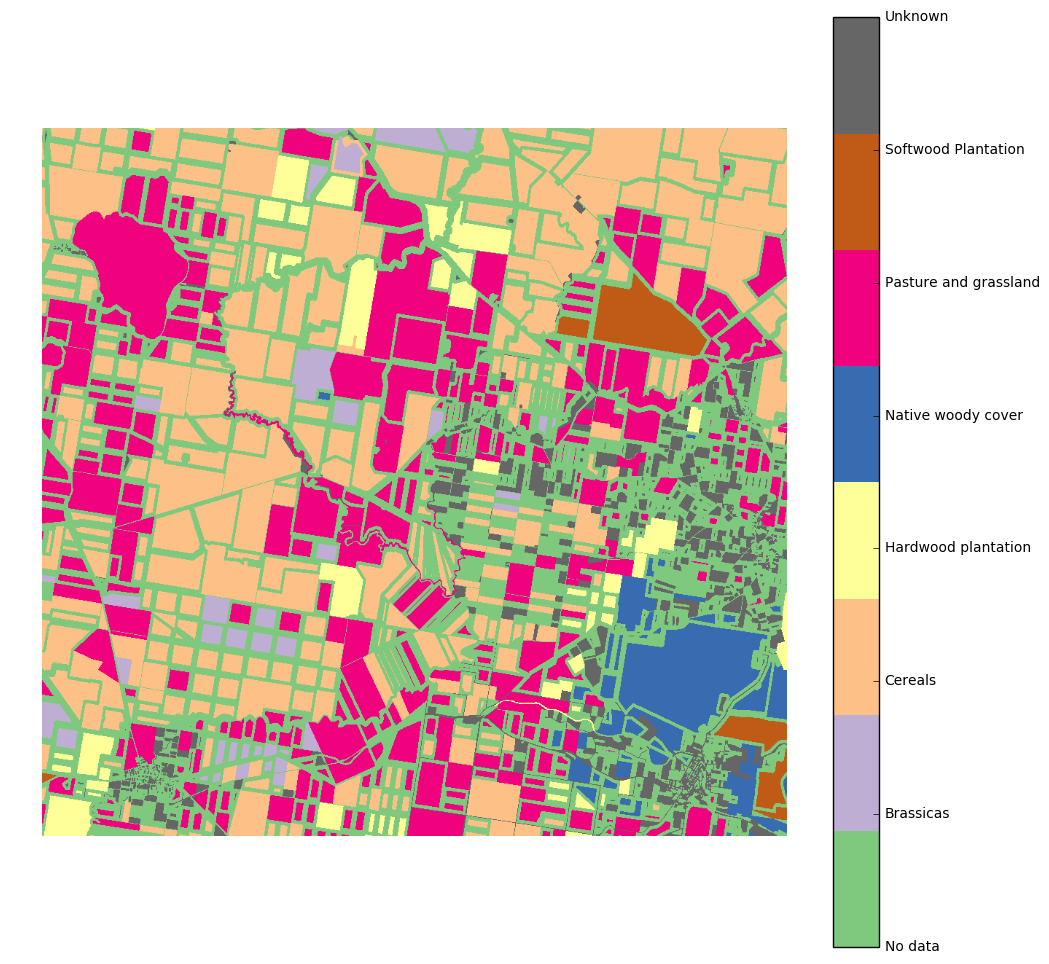

In [13]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(array, cmap=plt.cm.get_cmap('Accent', len(unique_classes)))
plt.colorbar(ticks=range(len(unique_classes)), format=plt.FuncFormatter(lambda val, loc: unique_classes[val]))
plt.show()